In [1]:
import sys
# Use this block to download extra dependencies


In [2]:
import torchvision
import torch
import pydicom as dicom

import numpy as np
import pandas as pd
from functools import partial
import rnsa

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
model_save_path = '/home/tstrebel/models/rnsa-densenet.pt'
train_img_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images'
annotations_file_path = '/home/tstrebel/assets/rnsa-pneumonia/stage_2_train_labels.csv.zip'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
label_df = pd.read_csv(annotations_file_path).groupby('patientId').first().reset_index()

X_train, X_test = train_test_split(label_df, test_size=.2, stratify=label_df.Target, random_state=99)
X_val, X_test, = train_test_split(X_test, test_size=.4, stratify=X_test.Target, random_state=99)
train_ix, val_ix, test_ix = X_train.index.tolist(), X_val.index.tolist(), (X_test.index.tolist())
del(X_train)
del(X_val)
del(X_test)
print('train {:,} - validate {:,} - test {:,}'.format(len(train_ix), len(val_ix), len(test_ix)))
# Single channel mean & standard deviation.
mean = [0.5]
std = [0.225]

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(512),
    torchvision.transforms.CenterCrop(448),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std),
])

label_transform = torchvision.transforms.Compose([
    partial(torch.tensor, dtype=torch.float),
    partial(torch.unsqueeze, dim=0),
])
    
test_dataset = rnsa.RNSADataset(train_img_dir, annotations_file_path, test_ix, transform, label_transform)
test_data_loader = rnsa.get_data_loader(test_dataset, batch_size=32)

train 21,347 - validate 3,202 - test 2,135


In [6]:
model, best_loss, best_acc, lr = rnsa.load_checkpoint(model_save_path, 'cpu')

print('checkpoint best loss: {:.4}'.format(best_loss))
print('checkpoint best acc: {:.4}'.format(best_acc))

checkpoint best loss: 0.3685
checkpoint best acc: 0.841


In [7]:
with torch.no_grad():
    running_targets = torch.Tensor(0, 1).to(device)
    running_outputs = torch.Tensor(0, 1).to(device)
    
    model.eval()
    for inputs, targets in test_data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        running_targets = torch.vstack((running_targets, targets))
        running_outputs = torch.vstack((running_outputs, outputs)) 

best threshold	0.4145
accuracy:	0.8262
precision:	0.7163
recall:		0.7844
f1:		0.7488



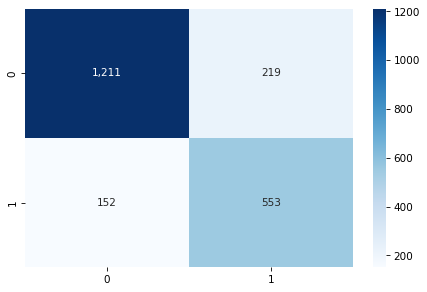

In [34]:
y_true = running_targets.cpu().numpy()
y_proba = torch.sigmoid(running_outputs).cpu().numpy()

fpr, tpr, roc_thresholds = metrics.roc_curve(y_true, y_proba)
g_means = np.sqrt(tpr * (1-fpr))

precision, recall, pr_thresholds = metrics.precision_recall_curve(y_true, y_proba)
f1_scores = (2 * precision * recall) / (precision + recall)

ix = np.argmax(f1_scores)
best_thresh = pr_thresholds[ix]
# ix = np.argmax(g_means)
# best_thresh = roc_thresholds[ix]

y_pred = y_proba >= best_thresh

accuracy_score = metrics.accuracy_score(y_true, y_pred)
precision_score = metrics.precision_score(y_true, y_pred)
recall_score = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)

print('best threshold\t{:.4f}'.format(best_thresh))
print('accuracy:\t{:.4f}'.format(accuracy_score))
print('precision:\t{:.4f}'.format(precision_score))
print('recall:\t\t{:.4f}'.format(recall_score))
print('f1:\t\t{:.4f}'.format(f1_score))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
plt.show()

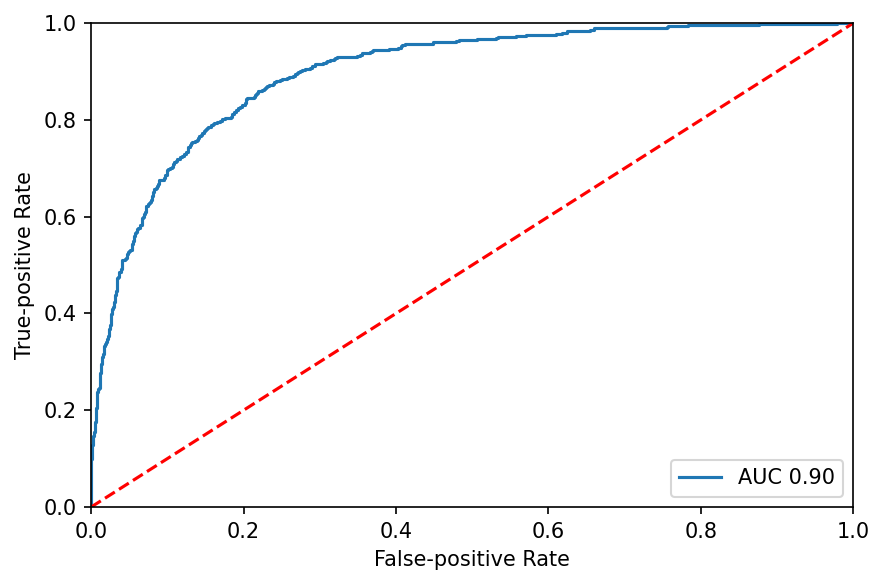

In [32]:
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

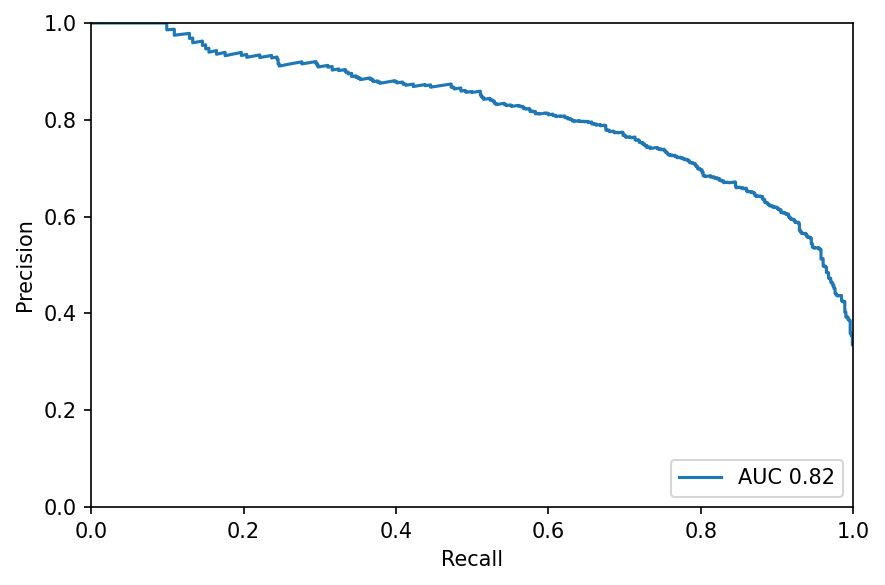

In [35]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()